# Data exploration

In [1]:
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logit
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame



# Load the GEBCO netCDF data grid

I will use the xarray package for handling the netCDF


In [2]:
#  downloaded from https://download.gebco.net/
file_path = "../data/gebco_2023_n51.5918_s45.022_w-68.4229_e-57.6123.nc"
dataset = xr.open_dataset(file_path)
dataset

<xarray.Dataset> Size: 8MB
Dimensions:    (lat: 1577, lon: 2594)
Coordinates:
  * lat        (lat) float64 13kB 45.02 45.03 45.03 45.04 ... 51.58 51.59 51.59
  * lon        (lon) float64 21kB -68.42 -68.41 -68.41 ... -57.62 -57.62 -57.61
Data variables:
    elevation  (lat, lon) int16 8MB ...
Attributes: (12/36)
    title:                           The GEBCO_2023 Grid - a continuous terra...
    summary:                         The GEBCO_2023 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    references:                      DOI: 10.5285/f98b053b-0cbc-6c23-e053-6c8...
    node_offset:                     1.0

Let's look at details about the elevation variable, which is the main variable of interest for us.


In [3]:
dataset.elevation

<xarray.DataArray 'elevation' (lat: 1577, lon: 2594)> Size: 8MB
[4090738 values with dtype=int16]
Coordinates:
  * lat      (lat) float64 13kB 45.02 45.03 45.03 45.04 ... 51.58 51.59 51.59
  * lon      (lon) float64 21kB -68.42 -68.41 -68.41 ... -57.62 -57.62 -57.61
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

We can see the associated units for this variable is meters

Each elevation variable is associated with a lat / lon coordinate.

For example, if I have the coordinates: 47.87, -60.24, here is how we get the elevation:

In [4]:
lat = 47.87
lon = -60.24
# use the "nearest" method to determine how to deal with the miss elevation value for this coordinate pair 
subset = dataset.sel(lat=lat, lon=lon, method="nearest")
print(f"""The elevation at ({lat},{lon}) is {subset.elevation.values}{subset.elevation.units}.""")

The elevation at (47.87,-60.24) is -492m.


That looks good. 

### presenting the elevation 2D array as a map 

`xarray` package makes this super easy.


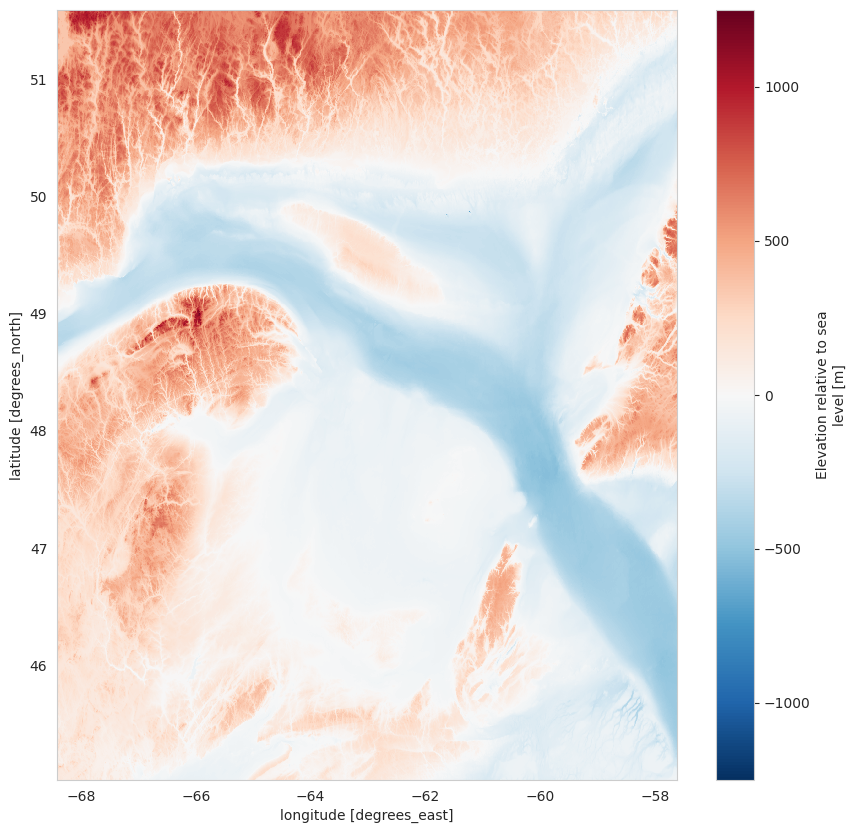

In [5]:

fig, ax = plt.subplots(figsize=(10, 10))

elevation_xa = dataset.elevation
elevation_xa.plot(ax=ax)


### Nice!!!

# Get hold of the main dataset

https://open.canada.ca/data/en/dataset/1989de32-bc5d-c696-879c-54d422438e64
https://open.canada.ca/data/en/dataset/1989de32-bc5d-c696-879c-54d422438e64/resource/6548c805-4b6f-4439-8e5b-6dd293684794


In [6]:
# load the data into a pandas dataframe
df = pd.read_csv("../data/sGSL-September-RV-FGP.csv", encoding="windows-1252")
df["french_name__nom_francais"][:50]


0                     Morue franche
1                   Plie canadienne
2                        Plie grise
3                 Hareng atlantique
4                           Capelan
5                     Raie épineuse
6               Grosse poule de mer
7               Lycode non-spécifée
8               Crevette - Pandalus
9        Crabe "queen" non-spécifié
10                    Morue franche
11                  Plie canadienne
12                          Capelan
13                    Raie épineuse
14              Lycode non-spécifée
15              Crevette - Pandalus
16       Crabe "queen" non-spécifié
17                    Morue franche
18                  Plie canadienne
19    Chaboisseau à dix-huit-épines
20              Grosse poule de mer
21              Lycode non-spécifée
22              Crevette - Pandalus
23       Crabe "queen" non-spécifié
24                    Morue franche
25                  Plie canadienne
26                Hareng atlantique
27                        Ga

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166694 entries, 0 to 166693
Data columns (total 14 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   year__annee                      166694 non-null  int64  
 1   month__mois                      166694 non-null  int64  
 2   day__jour                        166694 non-null  int64  
 3   start_hour__heure_de_depart      166694 non-null  int64  
 4   start_minute__minute_de_depart   166694 non-null  int64  
 5   latitude                         166694 non-null  float64
 6   longitude                        166694 non-null  float64
 7   gear__equipement                 166694 non-null  object 
 8   species__espece                  166694 non-null  int64  
 9   french_name__nom_francais        165805 non-null  object 
 10  english_name__nom_anglais        166664 non-null  object 
 11  latin_name__nom_latin            159864 non-null  object 
 12  we

The data looks very clean. All the fields are non-null and the data types look promising.

In [8]:
df.head()

,year__annee,month__mois,day__jour,start_hour__heure_de_depart,start_minute__minute_de_depart,latitude,longitude,gear__equipement,species__espece,french_name__nom_francais,english_name__nom_anglais,latin_name__nom_latin,weight_caught__poids_pris,number_caught__quantite_attrape
0,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl,10,Morue franche,Atlantic cod,Gadus morhua,335.669374,261.985853
1,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl,40,Plie canadienne,American plaice,Hippoglossoides platessoides,158.100000,1035.400000
2,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl,41,Plie grise,Witch flounder,Glyptocephalus cynoglossus,1.250000,2.500000
3,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl,60,Hareng atlantique,Atlantic herring,Clupea harengus,0.000000,0.822368
4,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl,64,Capelan,Capelin,Mallotus villosus,0.000000,231.989202


In [9]:
df.describe()

,year__annee,month__mois,day__jour,start_hour__heure_de_depart,start_minute__minute_de_depart,latitude,longitude,species__espece,weight_caught__poids_pris,number_caught__quantite_attrape
count,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000,166694.000000
mean,2004.735551,8.994835,16.862976,11.549090,29.460245,47.428990,-62.767278,3005.727201,11.842372,63.417712
std,11.122060,0.141902,6.970248,6.932314,17.305093,0.769587,1.269305,3038.585747,194.071994,1344.227220
min,1971.000000,8.000000,1.000000,0.000000,0.000000,45.693083,-65.914667,10.000000,0.000000,0.000000
25%,1997.000000,9.000000,11.000000,6.000000,15.000000,46.899583,-63.760583,300.000000,0.023596,0.000000
50%,2006.000000,9.000000,17.000000,11.000000,30.000000,47.445333,-62.800000,2316.000000,0.238636,0.597400
75%,2014.000000,9.000000,23.000000,18.000000,45.000000,48.016667,-61.780833,6113.000000,1.998513,4.861111
max,2022.000000,10.000000,31.000000,23.000000,59.000000,49.146417,-60.099500,9999.000000,39288.666500,369467.942165


From the above, we can glean a few details:

- The dataset ranges from year 1971 to 2022
- There are 166694 observations
- In general these data were collected in September: mean month=8.99 std=0.14

### Now let's drill a bit deeper into the data

## Species


### How many different species have been observed?


In [10]:
counts = df["english_name__nom_anglais"].value_counts()
print(counts.shape)

(533,)


There were 533 different species reported in this dataset

### Which were the most common by weight? 


In [11]:
df.loc[:, ["english_name__nom_anglais", "weight_caught__poids_pris"]].groupby("english_name__nom_anglais").sum().sort_values("weight_caught__poids_pris",
                                                                                                                             ascending=False)[:10]

,weight_caught__poids_pris
english_name__nom_anglais,
Atlantic cod,449199.443643
Atlantic herring,361825.373936
American plaice,184805.113381
Redfish unidentified,151411.641558
Boreal red shrimp unidentified,136369.898373
Queen crab unidentified,97292.607438
American lobster,76858.380857
Winter flounder,65924.883460
Snow crab,35979.203155


### how about the most common by abundance? 

In [12]:
df.loc[:, ["english_name__nom_anglais", "number_caught__quantite_attrape"]].groupby("english_name__nom_anglais").sum().sort_values(
    "number_caught__quantite_attrape", ascending=False)[:10]

,number_caught__quantite_attrape
english_name__nom_anglais,
Atlantic herring,2.817182e+06
Capelin,2.305644e+06
American plaice,1.205424e+06
Rainbow smelt,1.028485e+06
Atlantic cod,6.449475e+05
Redfish unidentified,6.262165e+05
Winter flounder,3.637473e+05
Snow crab,2.493523e+05
American lobster,1.770155e+05


# Sites / Samples

When looking at the dataset, we can see that there are many rows that correspond to a date-time-coordinate combination

I will refer to this combination from hereon out as a fishing set, or _set_ for short

Let's create a new dataframe the contains a unique list of sets


In [13]:

# create a helper function to create a unique string for each set 
def get_set_string(row):
    year = f"{row['year__annee']}"
    month = f"{str(row['month__mois']).rjust(2, '0')}"
    day = f"{str(row['day__jour']).rjust(2, '0')}"
    hour = f"{row['start_hour__heure_de_depart']}"
    minute = f"{row['start_minute__minute_de_depart']}"
    lat = f"{row['latitude']}"
    lon = f"{row['longitude']}"
    return "-".join([year, month, day, hour, minute, lat, lon])


# add a new col called "set" to the DF
df["set_string"] = df.apply(get_set_string, axis=1)
# sort the DF by this new column so that the rows will be in descending chronological order
df.sort_values("set_string", inplace=True)

df.head()["set_string"]

11    1971-09-07-11-15-47.9666666666667--65.11666666...
16    1971-09-07-11-15-47.9666666666667--65.11666666...
15    1971-09-07-11-15-47.9666666666667--65.11666666...
14    1971-09-07-11-15-47.9666666666667--65.11666666...
13    1971-09-07-11-15-47.9666666666667--65.11666666...
Name: set_string, dtype: object

In [14]:


sets = df["set_string"].unique()
sets.shape


(7257,)

OK so we go from 167K observations to only 7257 sets

The set strings are ugly let's give it a prettier identifier...

In [15]:

set_string_2_id_map = dict()
i = 1
for s in sets:
    set_string_2_id_map[s] = i
    i += 1



In [16]:
df["set_id"] = df["set_string"].map(set_string_2_id_map)
df.drop(columns=["set_string"], inplace=True)

In [17]:
df.head()["set_id"]

11    1
16    1
15    1
14    1
13    1
Name: set_id, dtype: int64

### Wonderful. Now let's divide the datasets into two tables: `species_df` and `set_df`

In [18]:

set_cols = ['set_id', 'year__annee', 'month__mois', 'day__jour',
            'start_hour__heure_de_depart', 'start_minute__minute_de_depart',
            'latitude', 'longitude', 'gear__equipement', ]

species_cols = ['set_id', 'species__espece',
                'french_name__nom_francais', 'english_name__nom_anglais',
                'latin_name__nom_latin', 'weight_caught__poids_pris',
                'number_caught__quantite_attrape', ]

species_df = df.copy()
set_df = df.copy()
species_df = species_df.loc[:, species_cols]
set_df = set_df.loc[:, set_cols].drop_duplicates()

In [19]:
set_df

,set_id,year__annee,month__mois,day__jour,start_hour__heure_de_depart,start_minute__minute_de_depart,latitude,longitude,gear__equipement
11,1,1971,9,7,11,15,47.966667,-65.116667,Yankee #36 otter trawl
23,2,1971,9,7,12,45,47.933333,-65.250000,Yankee #36 otter trawl
24,3,1971,9,7,15,5,47.916667,-65.516667,Yankee #36 otter trawl
0,4,1971,9,7,8,25,48.016667,-64.766667,Yankee #36 otter trawl
35,5,1971,9,8,10,25,48.216667,-64.483333,Yankee #36 otter trawl
...,...,...,...,...,...,...,...,...,...
166627,7253,2022,9,30,11,47,45.888083,-63.146750,Western IIA trawl
166646,7254,2022,9,30,15,4,45.909500,-62.769083,Western IIA trawl
166671,7255,2022,9,30,18,23,45.863500,-62.338417,Western IIA trawl
166597,7256,2022,9,30,4,29,46.098000,-63.412250,Western IIA trawl


In [20]:
set_df["set_id"].unique().__len__()

7257

In [21]:
species_df

,set_id,species__espece,french_name__nom_francais,english_name__nom_anglais,latin_name__nom_latin,weight_caught__poids_pris,number_caught__quantite_attrape
11,1,40,Plie canadienne,American plaice,Hippoglossoides platessoides,82.970588,469.741176
16,1,2522,"Crabe ""queen"" non-spécifié",Queen crab unidentified,Chionoecetes sp.,24.705882,102.941176
15,1,2210,Crevette - Pandalus,Boreal red shrimp unidentified,Pandalus sp.,10293.088235,514.705882
14,1,642,Lycode non-spécifée,Lycodes unidentified,Lycodes sp.,23.676471,43.235294
13,1,201,Raie épineuse,Thorny skate,Amblyraja radiata,0.702824,0.702824
...,...,...,...,...,...,...,...
166611,7257,8621,Chalina digitée,Eyed finger sponge,Haliclona (Haliclona) oculata,0.004916,0.000000
166613,7257,9305,Zostère,Eel grass,Zostera subg. Zostera marina,0.021629,0.000000
166614,7257,9630,Débris organiques,Organic debris,NaN,0.507303,0.000000
166607,7257,361,Épinoche à trois épines,Three-spined stickleback,Gasterosteus aculeatus,0.000983,0.983146


In [22]:
species_df["set_id"].unique().__len__()


7257

Great, we have back the 7257 rows

There are a few things I want to do to the sets DF:

1. combine the year, month, day columns into a datetime column
2. use the coordinates to retrieve and attach elevation data from the netCDF file above.

In [23]:
import datetime as dt


# create a helper function to get datetime from indiviual cols 
def get_dt(row):
    year = row['year__annee']
    month = row['month__mois']
    day = row['day__jour']
    hour = row['start_hour__heure_de_depart']
    minute = row['start_minute__minute_de_depart']
    return pd.to_datetime(dt.datetime(year, month, day, hour, minute))


set_df["dt"] = set_df.apply(get_dt, axis=1)
set_df["dt"].head()

11   1971-09-07 11:15:00
23   1971-09-07 12:45:00
24   1971-09-07 15:05:00
0    1971-09-07 08:25:00
35   1971-09-08 10:25:00
Name: dt, dtype: datetime64[ns]

In [24]:
# create a helper function to get datetime from indiviual cols 
def get_elevation(row):
    lat = f"{row['latitude']}"
    lon = f"{row['longitude']}"
    return dataset.sel(lat=lat, lon=lon, method="nearest").elevation.values


set_df["elevation"] = set_df.apply(get_elevation, axis=1).astype("int")

### So one very easy QC check would be to make sure there are no values above 0

In [25]:

mask = set_df["elevation"] > 0
set_df[mask]

,set_id,year__annee,month__mois,day__jour,start_hour__heure_de_depart,start_minute__minute_de_depart,latitude,longitude,gear__equipement,dt,elevation


In [26]:
set_df["elevation"].describe()


count    7257.000000
mean      -82.228331
std        69.539260
min      -383.000000
25%       -87.000000
50%       -61.000000
75%       -41.000000
max       -13.000000
Name: elevation, dtype: float64

Let's take a look at a histogram of the site elevations / depths

Text(0, 0.5, 'Count')

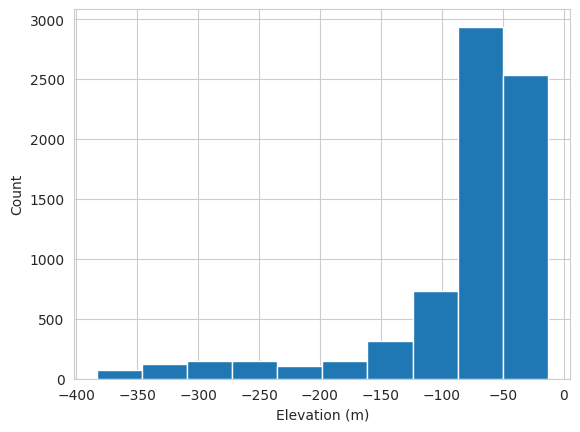

In [40]:
fig, ax = plt.subplots()

set_df["elevation"].hist(ax=ax)
ax.set_xlabel("Elevation (m)")
ax.set_ylabel("Count")

In [28]:
# finally, clean up the other rows that are no longer needed
set_df = set_df.drop(columns=['year__annee', 'month__mois', 'day__jour', 'start_hour__heure_de_depart', 'start_minute__minute_de_depart', 'gear__equipement', ])

It would be cool if we can display the sites on a map


Prep the geospatial data

In [29]:

geometry = [Point(xy) for xy in zip(set_df['longitude'], set_df['latitude'])]
gdf = GeoDataFrame(set_df, geometry=geometry)
gdf = gdf.set_crs(epsg=4269)

# this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
# it is in a weird projection
canada = canada.to_crs(epsg=4269)


Plotting the geospatial data

(45.6930833333333, 49.1464166666667)

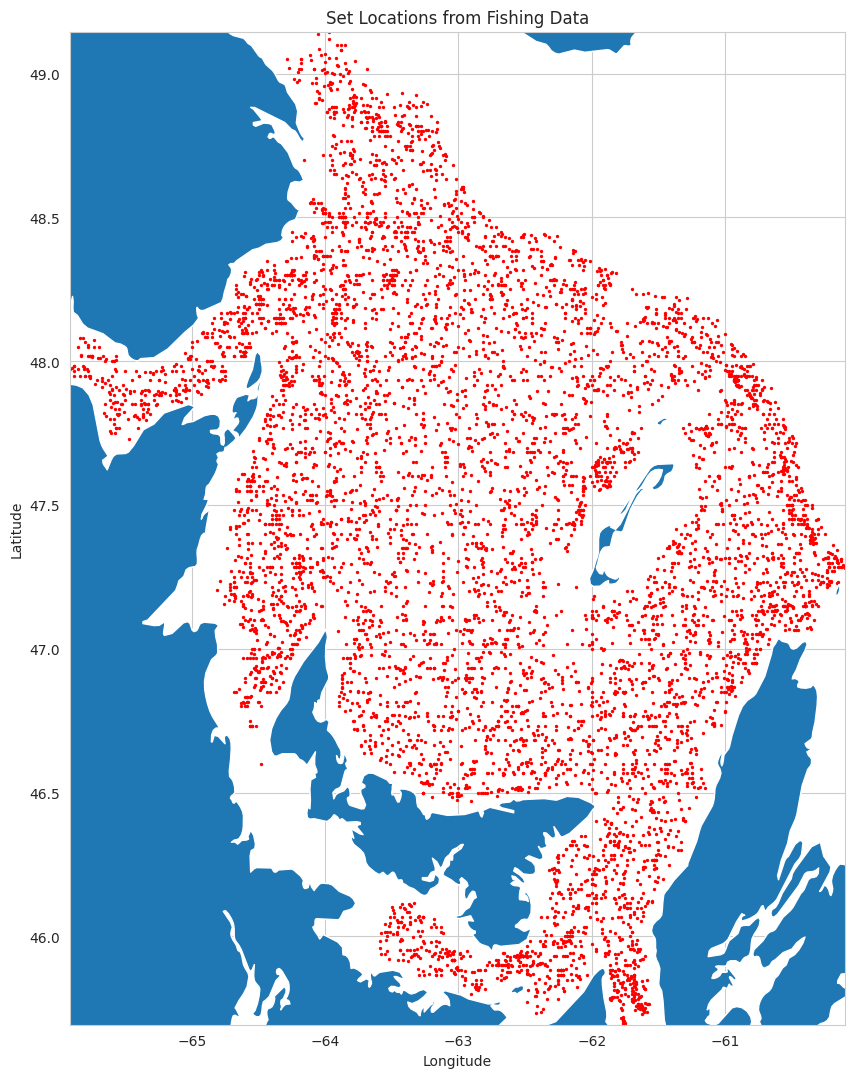

In [30]:
# create the figure and plot
fig, ax = plt.subplots(figsize=(10, 15))

# start by plotting the two geospatial dfs
gdf.plot(ax=ax, color='red', markersize=2)
canada.plot(ax=ax)

# set graph props
ax.set_title('Set Locations from Fishing Data', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')
ax.set_xlim((np.min(set_df["longitude"]), np.max(set_df["longitude"])))
ax.set_ylim((np.min(set_df["latitude"]), np.max(set_df["latitude"])))


Ok, so now let's add a few boolean cols to the dataframe:

1. `has_lobster`
1. `has_snowcrab`
1. `has_cod`
1. `has_redfish`
1. `has_herring`
1. `has_plaice`


In [31]:
# it would be nice if we can use the code instead of the name

target_species = ["Atlantic cod", "Snow crab", "Atlantic herring", "American lobster", "Redfish unidentified", "American plaice"]
mask = species_df["english_name__nom_anglais"].isin(target_species)
species_code_df = species_df[mask][["species__espece", "english_name__nom_anglais"]].drop_duplicates()

species_code_lookup = dict()
for index, row in species_code_df.iterrows():
    species_code_lookup[row["species__espece"]] = row["english_name__nom_anglais"]
species_code_lookup

{40: 'American plaice',
 10: 'Atlantic cod',
 60: 'Atlantic herring',
 23: 'Redfish unidentified',
 2550: 'American lobster',
 2526: 'Snow crab'}

In [32]:
species_df[mask][["species__espece", "english_name__nom_anglais", "latin_name__nom_latin"]].drop_duplicates()



,species__espece,english_name__nom_anglais,latin_name__nom_latin
11,40,American plaice,Hippoglossoides platessoides
10,10,Atlantic cod,Gadus morhua
26,60,Atlantic herring,Clupea harengus
86,23,Redfish unidentified,Sebastes sp.
396,2550,American lobster,Homarus americanus
2258,2526,Snow crab,Chionoecetes opilio


In [33]:
thinned_species_df = species_df[mask]
thinned_species_df

,set_id,species__espece,french_name__nom_francais,english_name__nom_anglais,latin_name__nom_latin,weight_caught__poids_pris,number_caught__quantite_attrape
11,1,40,Plie canadienne,American plaice,Hippoglossoides platessoides,82.970588,469.741176
10,1,10,Morue franche,Atlantic cod,Gadus morhua,78.210483,63.377460
18,2,40,Plie canadienne,American plaice,Hippoglossoides platessoides,25.645455,150.913636
17,2,10,Morue franche,Atlantic cod,Gadus morhua,37.511611,33.343654
24,3,10,Morue franche,Atlantic cod,Gadus morhua,275.085145,136.109838
...,...,...,...,...,...,...,...
166687,7255,2550,Homard américain,American lobster,Homarus americanus,146.311475,670.355191
166674,7255,60,Hareng atlantique,Atlantic herring,Clupea harengus,8.204918,354.781421
166591,7256,2550,Homard américain,American lobster,Homarus americanus,36.867978,85.533708
166601,7257,60,Hareng atlantique,Atlantic herring,Clupea harengus,1.926966,100.280899


In [34]:

# to do this we'll need to build a function that we can apply to the set DF

def has_species(species_code, set_id):
    mask = (thinned_species_df["set_id"] == set_id) & (thinned_species_df["species__espece"] == species_code)
    return thinned_species_df[mask].shape[0] > 0


for code in species_code_lookup.keys():
    set_df[species_code_lookup[code]] = set_df["set_id"].apply(lambda x: has_species(code, x))

set_df.head()


,set_id,latitude,longitude,dt,elevation,American plaice,Atlantic cod,Atlantic herring,Redfish unidentified,American lobster,Snow crab
11,1,47.966667,-65.116667,1971-09-07 11:15:00,-87,True,True,False,False,False,False
23,2,47.933333,-65.250000,1971-09-07 12:45:00,-73,True,True,False,False,False,False
24,3,47.916667,-65.516667,1971-09-07 15:05:00,-48,True,True,True,False,False,False
0,4,48.016667,-64.766667,1971-09-07 08:25:00,-80,True,True,True,False,False,False
35,5,48.216667,-64.483333,1971-09-08 10:25:00,-96,True,True,False,False,False,False


In [35]:
gdf

,set_id,latitude,longitude,dt,elevation,geometry
11,1,47.966667,-65.116667,1971-09-07 11:15:00,-87,POINT (-65.11667 47.96667)
23,2,47.933333,-65.250000,1971-09-07 12:45:00,-73,POINT (-65.25000 47.93333)
24,3,47.916667,-65.516667,1971-09-07 15:05:00,-48,POINT (-65.51667 47.91667)
0,4,48.016667,-64.766667,1971-09-07 08:25:00,-80,POINT (-64.76667 48.01667)
35,5,48.216667,-64.483333,1971-09-08 10:25:00,-96,POINT (-64.48333 48.21667)
...,...,...,...,...,...,...
166627,7253,45.888083,-63.146750,2022-09-30 11:47:00,-23,POINT (-63.14675 45.88808)
166646,7254,45.909500,-62.769083,2022-09-30 15:04:00,-25,POINT (-62.76908 45.90950)
166671,7255,45.863500,-62.338417,2022-09-30 18:23:00,-26,POINT (-62.33842 45.86350)
166597,7256,46.098000,-63.412250,2022-09-30 04:29:00,-16,POINT (-63.41225 46.09800)


## Let's display a map for each species, showing all sets and the sets where that catch was present.

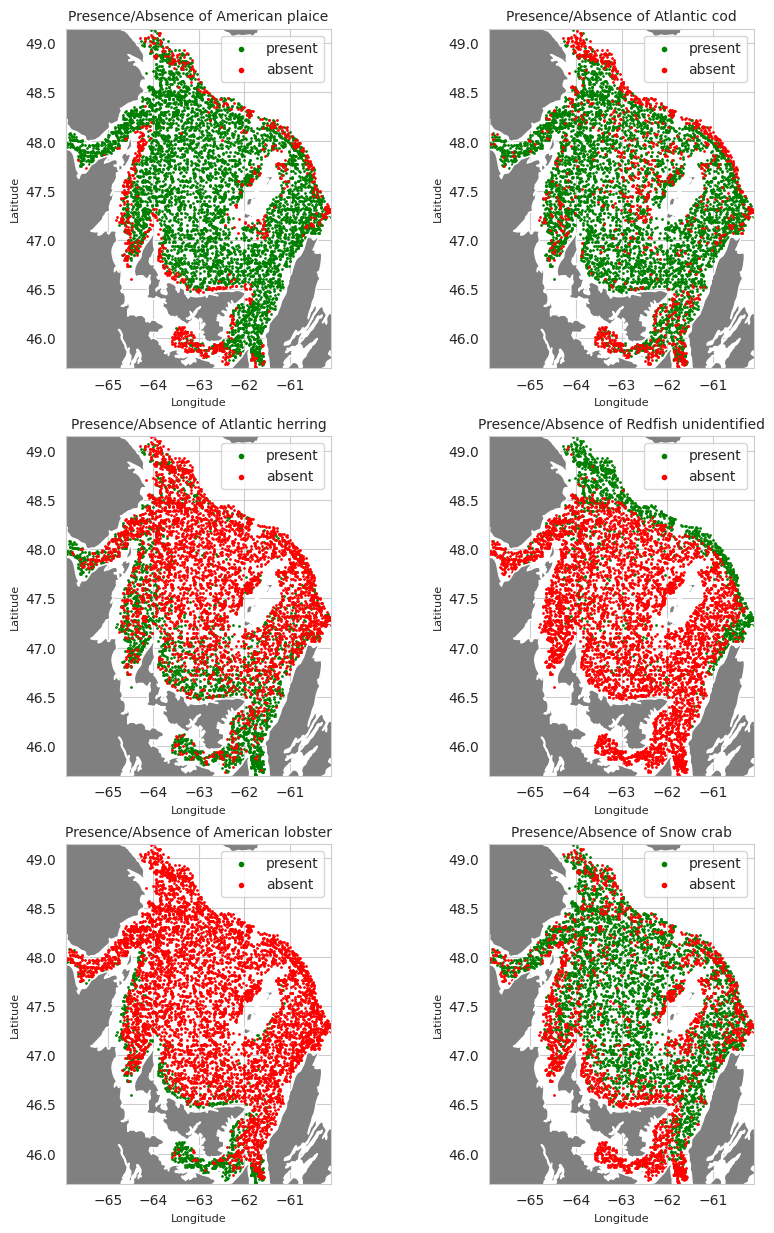

In [36]:
# recreate the geodf
geometry = [Point(xy) for xy in zip(set_df['longitude'], set_df['latitude'])]
gdf = GeoDataFrame(set_df, geometry=geometry)
gdf = gdf.set_crs(epsg=4269)

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))


# start by plotting the two geospatial dfs

# American plaice

def plot_species_presence_absence(code=40, ax=ax1):
    species = species_code_lookup[code]
    ax.set_title(f'Presence/Absence of {species}', fontsize=10)

    pmask = gdf[species] == True
    amask = gdf[species] == False
    gdf[pmask].plot(ax=ax, marker="o", color='green', markersize=1, label="present")
    gdf[amask].plot(ax=ax, marker="o", color='red', markersize=1, label="absent")
    canada.plot(ax=ax, color="grey")

    ax.set_xlim((np.min(gdf["longitude"]), np.max(gdf["longitude"])))
    ax.set_ylim((np.min(gdf["latitude"]), np.max(gdf["latitude"])))
    ax.set_xlabel('Longitude', fontsize=8)
    ax.set_ylabel('Latitude', fontsize=8)
    ax.legend(markerscale=3)


plot_species_presence_absence(code=40, ax=ax1)
plot_species_presence_absence(code=10, ax=ax2)
plot_species_presence_absence(code=60, ax=ax3)
plot_species_presence_absence(code=23, ax=ax4)
plot_species_presence_absence(code=2550, ax=ax5)
plot_species_presence_absence(code=2526, ax=ax6)



In [1]:


# start by bringing in the dataset from the previous step

# now we will want to create a dict to manage every we want to run in the logistic regressions
default_predictors = ['latitude', 'longitude', 'elevation']

species_dict = {
    'American plaice': {"predictors": default_predictors},
    'Atlantic cod': {"predictors": default_predictors},
    'Atlantic herring': {"predictors": default_predictors},
    'Redfish unidentified': {"predictors": default_predictors},
    'American lobster': {"predictors": default_predictors},
    'Snow crab': {"predictors": default_predictors},
}

In [2]:
set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7257 entries, 11 to 166605
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   set_id                7257 non-null   int64         
 1   latitude              7257 non-null   float64       
 2   longitude             7257 non-null   float64       
 3   dt                    7257 non-null   datetime64[ns]
 4   elevation             7257 non-null   int64         
 5   American plaice       7257 non-null   bool          
 6   Atlantic cod          7257 non-null   bool          
 7   Atlantic herring      7257 non-null   bool          
 8   Redfish unidentified  7257 non-null   bool          
 9   American lobster      7257 non-null   bool          
 10  Snow crab             7257 non-null   bool          
dtypes: bool(6), datetime64[ns](1), float64(2), int64(2)
memory usage: 382.7 KB


In [3]:

# For each species, we will fit a model
species_list = list(species_dict.keys())
for species in species_list:
    mydict = species_dict[species]
    predictors = mydict["predictors"]
    # make sure to add a column for the constant 
    m = Logit(set_df[species], sm.add_constant(set_df[predictors]))
    m = m.fit()
    mydict["model"] = m


Optimization terminated successfully.
         Current function value: 0.349219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.276586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.189613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.596130
         Iterations 5


In [4]:

# Let's get a table of the parameter estimations for each species and indicate whether or not they are significant
param_df = pd.DataFrame(columns=["const"] + default_predictors)


def get_coef_display(row):
    mystr = str(round(row["Coef."], 4))
    p = row["P>|z|"]
    if p <= 0.001:
        mystr += " [***]"
    elif p <= 0.01:
        mystr += " [**]"
    elif p <= 0.05:
        mystr += " [*]"
    return mystr


for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_param_df = summary.tables[1]
    params = temp_param_df.apply(get_coef_display, axis=1)
    param_df.loc[species] = params

param_df

,const,latitude,longitude,elevation
American plaice,-30.0087 [***],1.444 [***],0.5609 [***],0.0131 [***]
Atlantic cod,-30.3012 [***],1.0935 [***],0.2946 [***],0.0163 [***]
Atlantic herring,45.3376 [***],-1.8664 [***],-0.6723 [***],-0.0053 [***]
Redfish unidentified,-17.6596 [***],0.5059 [***],0.1757 [***],-0.038 [***]
American lobster,55.5688 [***],-1.9333 [***],-0.5996 [***],0.1006 [***]
Snow crab,-35.5849 [***],1.1284 [***],0.2703 [***],0.0035 [***]


In [6]:

for species in species_list:
    set_df[f"p_{species}"] = species_dict[species]["model"].predict(set_df[species_dict[species]["predictors"]])

set_df.head()



,set_id,latitude,longitude,dt,elevation,American plaice,Atlantic cod,Atlantic herring,Redfish unidentified,American lobster,Snow crab,p_American plaice,p_Atlantic cod,p_Atlantic herring,p_Redfish unidentified,p_American lobster,p_Snow crab
11,1,47.966667,-65.116667,1971-09-07 11:15:00,-87,True,True,False,False,False,False,0.742560,0.739406,0.672725,0.161558,0.004147,0.508925
23,2,47.933333,-65.250000,1971-09-07 12:45:00,-73,True,True,False,False,False,False,0.747351,0.761369,0.701367,0.095442,0.019126,0.492667
24,3,47.916667,-65.516667,1971-09-07 15:05:00,-48,True,True,True,False,False,False,0.759498,0.799379,0.744518,0.034769,0.231495,0.466465
0,4,48.016667,-64.766667,1971-09-07 08:25:00,-80,True,True,True,False,False,False,0.801242,0.783987,0.597900,0.134403,0.006161,0.548153
35,5,48.216667,-64.483333,1971-09-08 10:25:00,-96,True,True,False,False,False,False,0.830994,0.784135,0.494014,0.244544,0.000826,0.598464


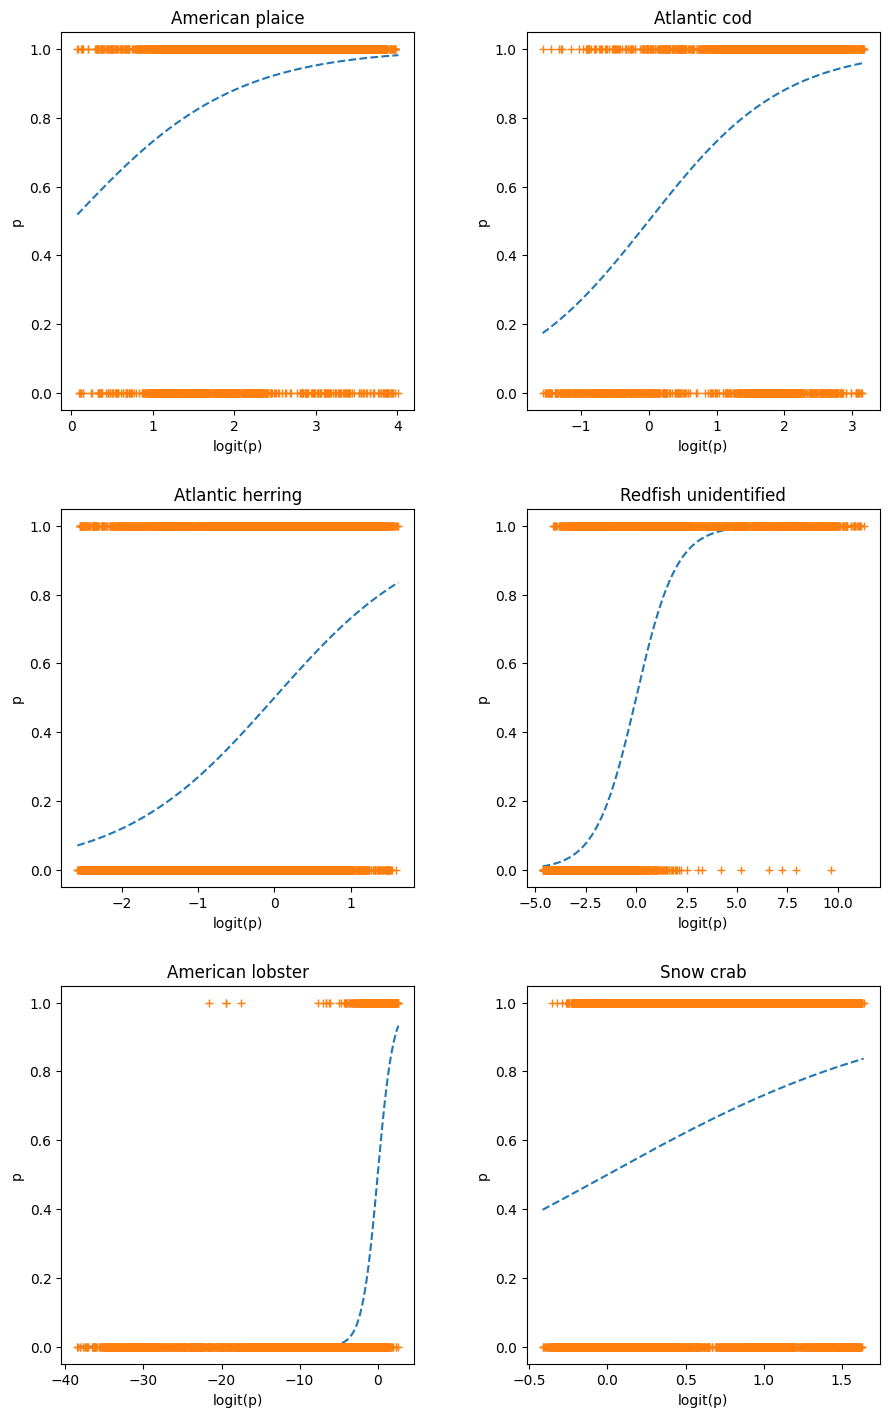

In [7]:

# plot relationship between values of logit(p) and p
# we will also display the actual values of the response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_logit_plot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    ax.plot(logit(temp_df[p_attr]), temp_df[p_attr], '--')
    ax.plot(logit(temp_df[p_attr]), temp_df[species], '+')
    ax.set_title(species)
    ax.set_xlabel('logit(p)')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_logit_plot(axs[i], species_list[i])

Text(0.5, 0.98, '')

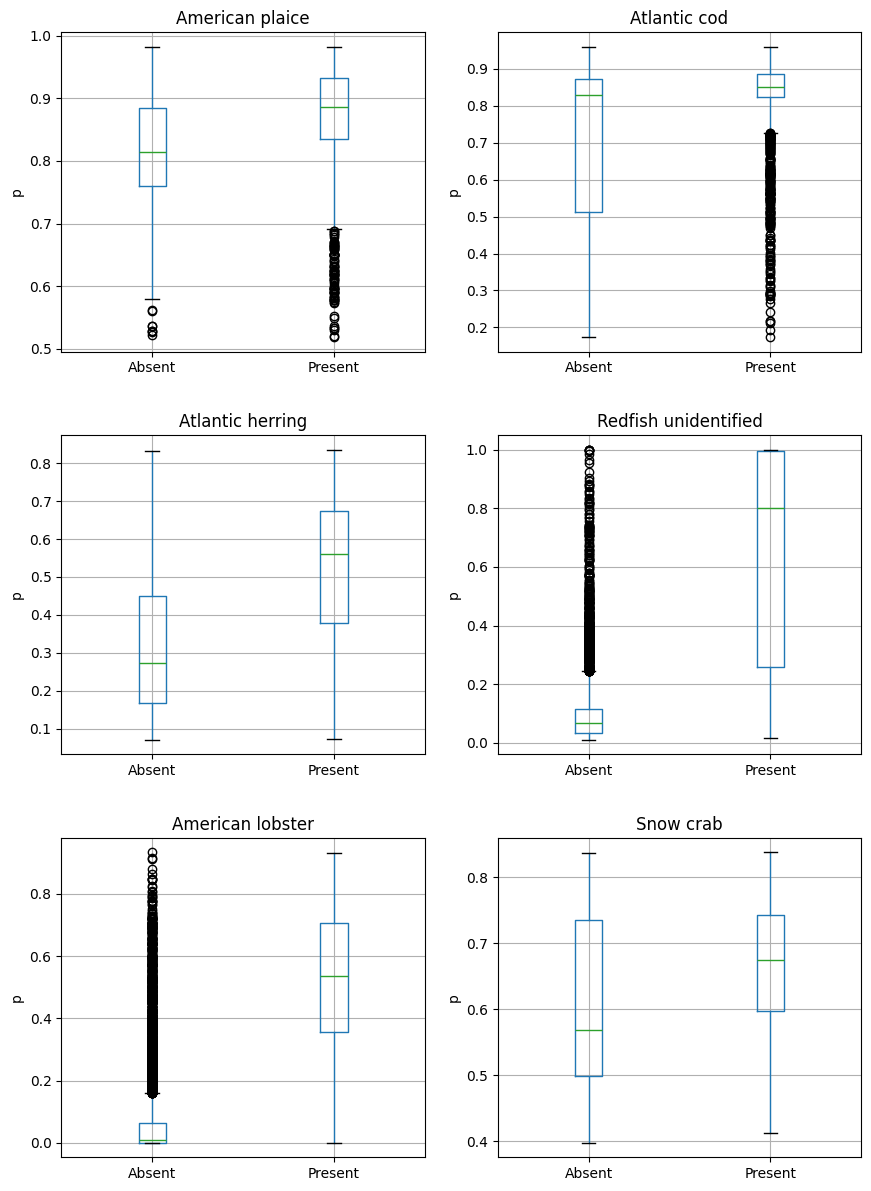

In [27]:

# create a box plot of the distribution of estimated odds for both values of the actual response

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def generate_boxplot(ax, species):
    p_attr = f'p_{species}'
    temp_df = set_df.sort_values(p_attr)
    temp_df.boxplot(p_attr, species, ax=ax)
    ax.set_title(species)
    ax.set_xticks([1, 2], ['Absent', 'Present'])
    ax.set_xlabel('')
    ax.set_ylabel('p')


for i in range(0, 6):
    generate_boxplot(axs[i], species_list[i])

fig.suptitle('')

In [9]:

# In looking at the above, we can see the distribution of estimated odds for each level of the actual response. For example, it can be noted that in Species like redfish and lobster, the model seems to be doing a very good job in predicting the odds. In lobster, in cases where lobster was absent, the average model odds estimate was close to zero. In other species, the model did not do a good job in explaining this. 


In [28]:

# let's create a table that presents the ACC, MCC, Precision and Recall for discrimination threshold = 0.5

eval_df = pd.DataFrame(columns=["Converged", "Pseudo R-squared", "TP", "TN", "FP", "FN", "ACC", "MCC", "Precision", "Recall", "F-score"])

for species in species_list:
    m = species_dict[species]["model"]
    summary = m.summary2()
    temp_summary = summary.tables[0]
    converged = temp_summary[1][6]
    r2 = temp_summary[3][1]
    tn, fp, fn, tp = m.pred_table().flatten()
    if tn:
        acc = (tp + tn) / np.sum([tn, fp, fn, tp])
        mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    else:
        acc = np.nan
        mcc = np.nan

    prc = tp / (tp + fp)
    rec = tp / (tp + fn)
    fscore = 2 * ((prc * rec) / (prc + rec))

    params = [converged, r2, tp, tn, fp, fn, acc, mcc, prc, rec, fscore]
    eval_df.loc[species] = params

eval_df

,Converged,Pseudo R-squared,TP,TN,FP,FN,ACC,MCC,Precision,Recall,F-score
American plaice,1.0000,0.067,6319.0,0.0,938.0,0.0,NaN,NaN,0.870745,1.000000,0.930907
Atlantic cod,1.0000,0.103,5882.0,310.0,994.0,71.0,0.853245,0.388693,0.855439,0.988073,0.916985
Atlantic herring,1.0000,0.155,1754.0,3559.0,814.0,1130.0,0.732121,0.431921,0.683022,0.608183,0.643434
Redfish unidentified,1.0000,0.479,1063.0,5502.0,116.0,576.0,0.904644,0.711781,0.901612,0.648566,0.754436
American lobster,1.0000,0.466,549.0,6047.0,238.0,423.0,0.908916,0.577182,0.697586,0.564815,0.624218
Snow crab,1.0000,0.045,4467.0,650.0,1928.0,212.0,0.705112,0.305947,0.698514,0.954691,0.806755


<Axes: >

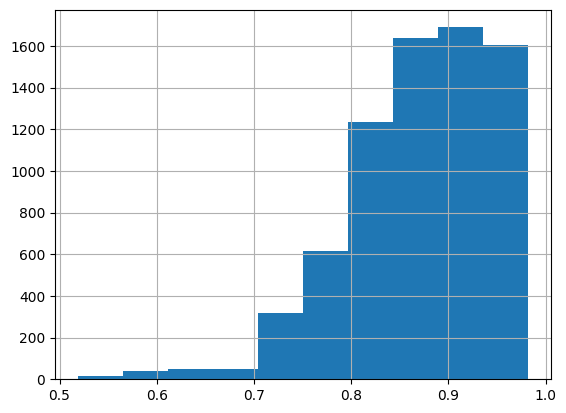

In [11]:
# Precision (also known as positive predictive value) is the fraction of correct estimates of the positive estimates:
# Recall (also known as the true positive rate, or sensitivity) is the fraction of correct estimates of the positive response
# Specificity (also known as the true negative rate) is the fraction of correct estimates of the negative response:
# F1-score (sometimes called F-measure, or Dice coefficient) is the harmonic mean of the precision and recall:


# what is going on with plaice?? 

m = species_dict["American plaice"]["model"]

set_df["p_American plaice"].hist()

# interesting.. plaice is  just going to bet on it always being present.


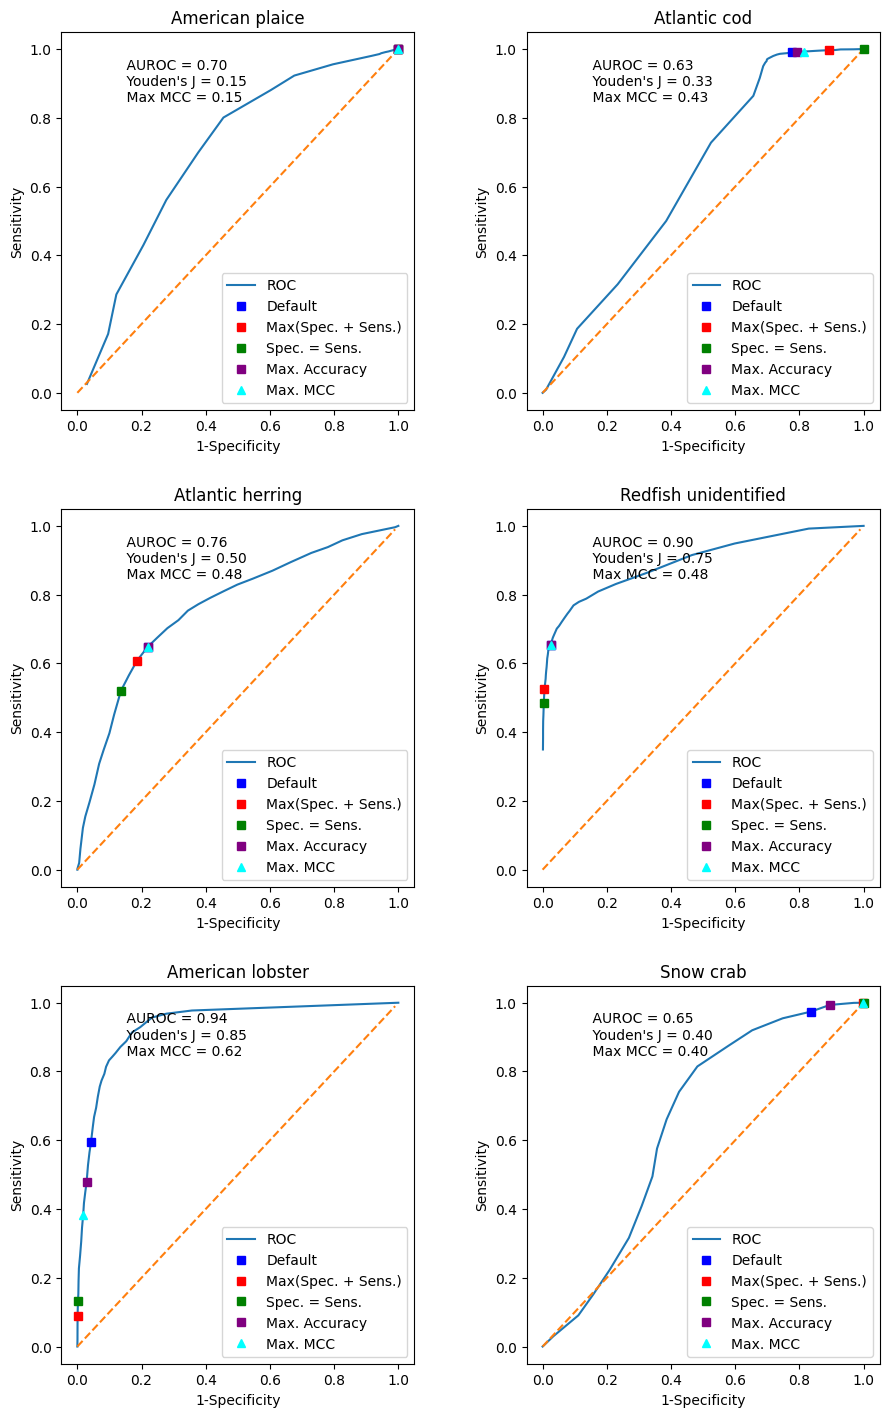

In [34]:



discr_th_df = pd.DataFrame(columns=["Default", "Max(Spec. + Sens.)", "Spec. = Sens.", "Max. ACC", "Max. MCC"])

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

# Set discrimination thresholds
ths = np.arange(0., 1.0, 0.025)


def plot_roc(ax, species):
    """ Credit to lesson 08-01 from this course... """
    ax.set_title(species)
    ax.set_xlabel('1-Specificity')
    ax.set_ylabel('Sensitivity')

    # Containers
    sensitivity = []
    specificity = []
    accuracy = []
    matthews = []

    m = species_dict[species]["model"]

    # Main loop
    for th in ths:
        # Generate estimates
        conf_mat = m.pred_table(threshold=th)

        # Extract TN, FP, ...
        tn, fp, fn, tp = conf_mat.flatten()

        # Calculate sensitivity and specificity
        sens = (1. * tp) / (tp + fn)
        spec = (1. * tn) / (tn + fp)

        # Calculate ACC and MCC
        if tn and fp:
            # print(tn, fp, fn, tp)
            acc = (tp + tn) / np.sum(conf_mat)
            mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        else:
            acc = np.nan
            mcc = np.nan
        # Add to containers
        sensitivity.append(sens)
        specificity.append(spec)
        accuracy.append(acc)
        matthews.append(mcc)

    # Bind all the numbers together
    roc = pd.DataFrame({'discret_thr': ths,
                        'sensitivity': sensitivity,
                        'specificity': specificity,
                        '_specificity': [1 - x for x in specificity],
                        'accuracy': accuracy,
                        'matthews': matthews})

    # Sort by 1 - specificity so we can plot it easily
    roc = roc.sort_values(by="_specificity")
    ax.plot(roc._specificity, roc.sensitivity, label='ROC')
    ax.plot(np.arange(0., 1., 0.01), np.arange(0., 1., 0.01), '--')  # straight line x=y
    ax.legend(loc=4)

    # calculate the area under the curve
    auc = np.trapz(y=roc.sensitivity, x=roc._specificity)

    # Where threshold equal 0.5
    idx_default_th = np.where(roc.discret_thr == 0.5)[0][0]

    # Max sum of spec and sens
    idx_youdensj = np.argmax(roc.sensitivity + roc.specificity)

    # Balanced spec and sens
    idx_balance = np.argmin(np.abs(roc.sensitivity - roc.specificity))

    # Max accuracy
    idx_maxacc = np.argmax(roc.accuracy)

    # Max matthews
    idx_maxmcc = np.argmax(roc.matthews)

    ax.plot(roc._specificity[idx_default_th],
            roc.sensitivity[idx_default_th],
            's', color='blue',
            label='Default')

    ax.plot(roc._specificity[idx_youdensj],
            roc.sensitivity[idx_youdensj],
            's', color='red',
            label='Max(Spec. + Sens.)')

    ax.plot(roc._specificity[idx_balance],
            roc.sensitivity[idx_balance],
            's', color='green',
            label='Spec. = Sens.')

    ax.plot(roc._specificity[idx_maxacc],
            roc.sensitivity[idx_maxacc],
            's', color='purple',
            label='Max. Accuracy')

    ax.plot(roc._specificity[idx_maxmcc],
            roc.sensitivity[idx_maxmcc],
            '^', color='cyan',
            label='Max. MCC')

    ax.legend(loc=4)
    ax.text(x=0.1, y=0.8, s=f"""
    AUROC = {auc:.2f}
    Youden's J = {roc.discret_thr[idx_youdensj]:.2f}
    Max MCC = {roc.discret_thr[idx_maxmcc]:.2f}
    """, fontsize=10)

    species_ths = [0.5,
                   roc.discret_thr[idx_youdensj],
                   roc.discret_thr[idx_balance],
                   roc.discret_thr[idx_maxacc],
                   roc.discret_thr[idx_maxmcc]]
    discr_th_df.loc[species] = species_ths

    # print("Area under ROC curve = %1.2f" )


for i in range(0, 6):
    plot_roc(axs[i], species_list[i])


In [35]:
# now we need a table with the different discrimination thresholds
discr_th_df

,Default,Max(Spec. + Sens.),Spec. = Sens.,Max. ACC,Max. MCC
American plaice,0.5,0.150,0.125,0.425,0.150
Atlantic cod,0.5,0.325,0.125,0.450,0.425
Atlantic herring,0.5,0.500,0.550,0.475,0.475
Redfish unidentified,0.5,0.750,0.825,0.475,0.475
American lobster,0.5,0.850,0.800,0.550,0.625
Snow crab,0.5,0.400,0.350,0.450,0.400


In [14]:

# now for the piece de resistance!  Let's create some maps for predicting occurrences 

# let's go back to the elevation dataarray

# transform it to a dataframe. The indexes are lat and long but we want these to be columns in the dataframe.
elevation_df = elevation_xa.to_dataframe()
elevation_df = elevation_df.reset_index()

# make sure the columns match up with the predictor names
elevation_df.rename(columns={"lat": "latitude", "lon": "longitude"}, inplace=True)

# now, we will add a column for each species that predicts occurrence.
for species in species_list:
    model = species_dict[species]["model"]
    predictors = species_dict[species]["predictors"]
    elevation_df[f'p_{species}'] = model.predict(elevation_df[predictors])

elevation_df.head()



,latitude,longitude,elevation,p_American plaice,p_Atlantic cod,p_Atlantic herring,p_Redfish unidentified,p_American lobster,p_Snow crab
0,45.022917,-68.418750,86,0.125879,0.628382,0.998093,0.000059,1.0,0.064313
1,45.022917,-68.414583,87,0.127267,0.631795,0.998086,0.000056,1.0,0.064415
2,45.022917,-68.410417,88,0.128669,0.635195,0.998080,0.000054,1.0,0.064517
3,45.022917,-68.406250,93,0.134645,0.650611,0.998071,0.000044,1.0,0.064652
4,45.022917,-68.402083,95,0.137287,0.656897,0.998063,0.000041,1.0,0.064763


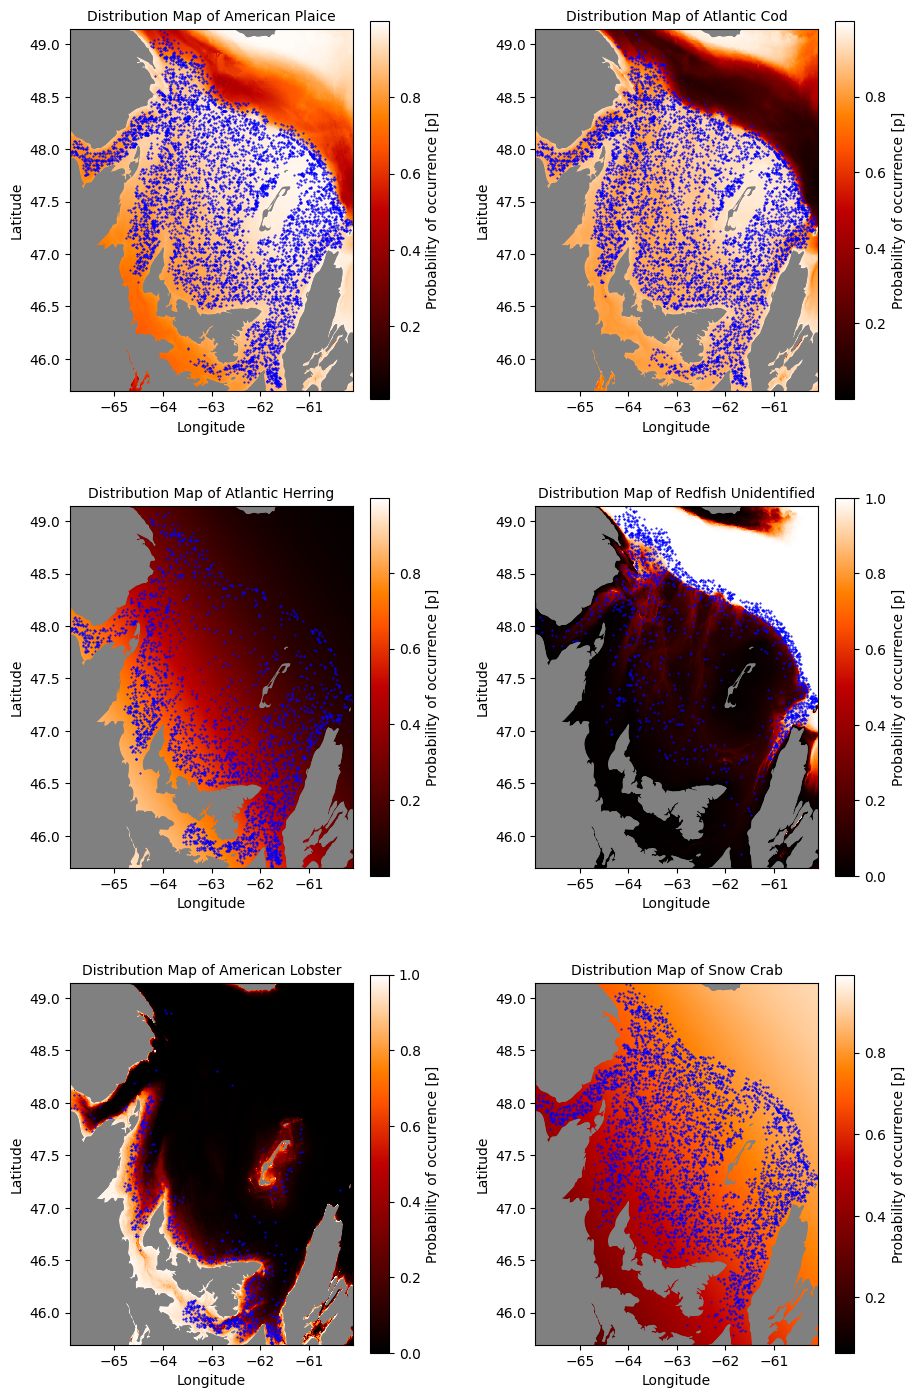

In [15]:

# plot a heatmap for each species

# create the figure and plot
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))
fig.tight_layout(pad=5)
axs = [ax1, ax2, ax3, ax4, ax5, ax6]


def plot_heatmap(ax, species):
    # change the array back to the original shape 
    prob_array = elevation_df[f"p_{species}"].to_numpy().reshape(elevation_xa.data.shape)
    # clone the elevation xarray data array to use for the probability mapping 
    prob_xa = elevation_xa.copy()
    prob_xa.data = prob_array
    # add some useful attributes
    prob_xa.attrs = {
        "long_name": "Probability of occurrence",
        "units": "p",
    }
    # plot the map
    prob_xa.plot(ax=ax, cmap="gist_heat")
    # let's overlay the sites where there were positive observations
    geometry = [Point(xy) for xy in zip(set_df['longitude'], set_df['latitude'])]
    gdf = GeoDataFrame(set_df, geometry=geometry)
    gdf = gdf.set_crs(epsg=4269)
    mask = gdf[species] == True
    gdf[mask].plot(ax=ax, marker=".", color='blue', markersize=1, label="present")

    # now we will overlay with land polygons
    # this geojson is from here: https://open.canada.ca/data/en/dataset/85efc01b-163f-ebba-2378-c43eadfb3b3f
    canada = gpd.read_file("../data/Canada_Provinical_boundaries_April2022_3931220444258526365.geojson")
    canada = canada.to_crs(epsg=4269)  # it is in a weird projection
    canada.plot(ax=ax, color='grey')

    # set graph props
    ax.set_title(f'Distribution Map of {species.title()}', fontsize=10)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize='medium')
    ax.set_xlim((np.min(set_df["longitude"]), np.max(set_df["longitude"])))
    ax.set_ylim((np.min(set_df["latitude"]), np.max(set_df["latitude"])))


for i in range(0, 6):
    plot_heatmap(axs[i], species_list[i])